# train.csv Genre and Audio Feature Analysis

Goal: identify influential audio features for genre classification, weaker features, and visualize feature distributions across genres.

In [53]:
# 基础库导入
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity


In [54]:
# Locate data path
data_dir_candidates = [Path('data') / 'song_info', Path('..') / 'data' / 'song_info']
for candidate in data_dir_candidates:
    if candidate.exists():
        data_dir = candidate
        break
else:
    raise FileNotFoundError('Could not find data/song_info path')

train_path = data_dir / 'train.csv'
train_path

PosixPath('../data/song_info/train.csv')

In [55]:
# Load data and drop helper column
df = pd.read_csv(train_path)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print(f'Rows: {len(df)}, Columns: {df.shape[1]}')
print('Genre distribution:')
print(df['track_genre'].value_counts())


Rows: 114000, Columns: 20
Genre distribution:
track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64


In [56]:
# Missing value overview
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_rate = (missing_counts / len(df)).round(4)
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_rate': missing_rate,
})
display(missing_summary)


,missing_count,missing_rate
album_name,1,0.0
track_name,1,0.0
artists,1,0.0
track_id,0,0.0
speechiness,0,0.0
time_signature,0,0.0
tempo,0,0.0
valence,0,0.0
liveness,0,0.0
instrumentalness,0,0.0


In [57]:
# Define numeric features and target
target_col = 'track_genre'
exclude_cols = ['track_id', 'artists', 'album_name', 'track_name', target_col]
num_cols = [c for c in df.columns if c not in exclude_cols]

X = df[num_cols]
y = df[target_col]

print('Numeric feature columns:', num_cols)


Numeric feature columns: ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [58]:
# Train/validation split and baseline (majority class)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

majority_class = y_train.mode()[0]
baseline_pred = pd.Series([majority_class] * len(y_test), index=y_test.index)

print('Training genre proportions:')
display(y_train.value_counts(normalize=True).rename('proportion').to_frame())
print(f'Baseline (predict majority "{majority_class}") accuracy: {accuracy_score(y_test, baseline_pred):.3f}')
print(f'Baseline macro F1: {f1_score(y_test, baseline_pred, average="macro"):.3f}')
print(f'Baseline weighted F1: {f1_score(y_test, baseline_pred, average="weighted"):.3f}')


Training genre proportions:


,proportion
track_genre,
metal,0.008772
death-metal,0.008772
guitar,0.008772
new-age,0.008772
alt-rock,0.008772
...,...
mandopop,0.008772
detroit-techno,0.008772
trip-hop,0.008772


Baseline (predict majority "acoustic") accuracy: 0.009
Baseline macro F1: 0.000
Baseline weighted F1: 0.000


Genre counts:


,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


/var/folders/8p/b5708bhd2pj92tqgr10m8cfh0000gn/T/ipykernel_24917/1875891826.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


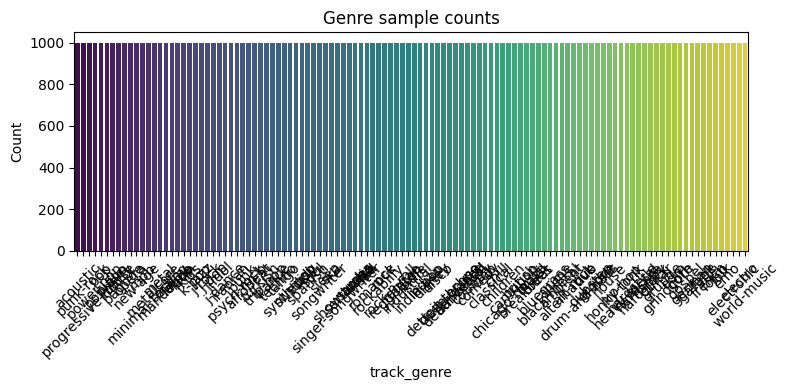

In [59]:
# Genre counts and visualization
genre_counts = df[target_col].value_counts()
print('Genre counts:')
display(genre_counts.to_frame('count'))

plt.figure(figsize=(8, 4))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre sample counts')
plt.ylabel('Count')
plt.xlabel('track_genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
# Mean of numeric features by genre
group_stats = df.groupby(target_col)[num_cols].mean().round(3)
display(group_stats)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
track_genre,,,,,,,,,,,,,,,
acoustic,42.483,214896.957,0.052,0.550,0.435,5.045,-9.448,0.816,0.043,0.567,0.038,0.153,0.424,119.011,3.885
afrobeat,24.399,248412.791,0.018,0.670,0.703,5.551,-7.789,0.511,0.087,0.271,0.253,0.185,0.699,119.213,3.946
alt-rock,33.943,235455.907,0.056,0.534,0.754,5.738,-6.191,0.641,0.055,0.122,0.054,0.210,0.518,124.634,3.939
alternative,24.337,222016.180,0.164,0.560,0.720,5.567,-6.079,0.606,0.070,0.148,0.038,0.201,0.496,122.232,3.942
ambient,44.191,237059.038,0.005,0.368,0.237,4.945,-18.601,0.620,0.042,0.777,0.676,0.129,0.167,111.113,3.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
techno,39.042,312311.477,0.026,0.684,0.746,5.515,-8.078,0.556,0.064,0.081,0.540,0.159,0.322,128.255,3.967
trance,37.635,269007.478,0.022,0.583,0.845,5.712,-6.330,0.484,0.080,0.036,0.424,0.234,0.277,133.277,3.957
trip-hop,34.460,274954.026,0.045,0.635,0.622,5.458,-9.240,0.483,0.076,0.226,0.384,0.190,0.478,118.744,3.945


,mutual_info
popularity,0.888585
acousticness,0.629225
tempo,0.594297
loudness,0.539318
duration_ms,0.527648
energy,0.492942
instrumentalness,0.412657
danceability,0.406617
valence,0.361935
speechiness,0.318526


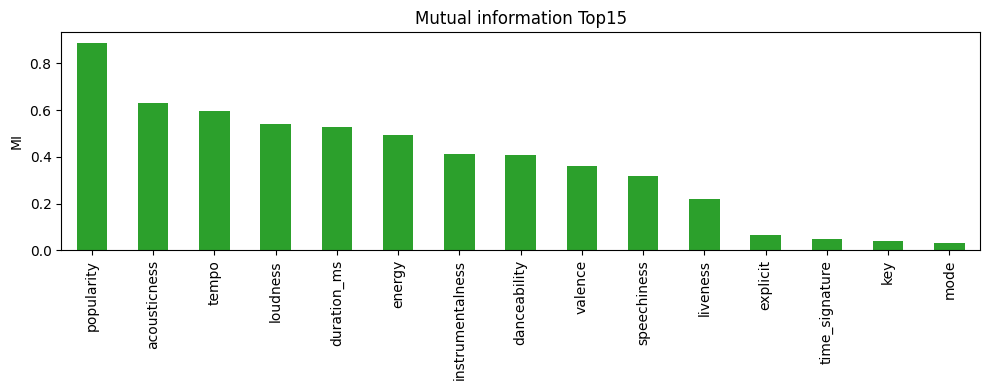

In [61]:
# Mutual information (single-feature association)
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=num_cols).sort_values(ascending=False)

display(mi_series.to_frame('mutual_info'))

plt.figure(figsize=(10, 4))
mi_series.head(15).plot(kind='bar', color='tab:green')
plt.title('Mutual information Top15')
plt.ylabel('MI')
plt.tight_layout()
plt.show()


In [64]:
# 探究音乐类型相似度（余弦）
# Find most similar genre pairs via cosine similarity
agg = df.groupby(target_col)[num_cols].mean()
scaled_agg = pd.DataFrame(StandardScaler().fit_transform(agg), index=agg.index, columns=agg.columns)

sim_matrix = cosine_similarity(scaled_agg)
sim_df = pd.DataFrame(sim_matrix, index=agg.index, columns=agg.index)

# Top 相似配对
pairs = []
for i, g1 in enumerate(sim_df.index):
    for j, g2 in enumerate(sim_df.columns):
        if j <= i:
            continue
        pairs.append((g1, g2, sim_df.loc[g1, g2]))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
print('Top 20 most similar genre pairs (cosine):')
for g1, g2, v in pairs_sorted[:20]:
    print(f"{g1} - {g2}: {v:.3f}")

# 每个类型的最近邻
print('Nearest neighbor per genre:')
for g in sim_df.index:
    sims = sim_df.loc[g].drop(g)
    nn = sims.idxmax()
    print(f"{g} -> {nn}: {sims[nn]:.3f}")


Top 20 most similar genre pairs (cosine):
singer-songwriter - songwriter: 1.000
latino - reggaeton: 0.992
punk - punk-rock: 0.979
reggae - reggaeton: 0.978
chicago-house - detroit-techno: 0.962
latino - reggae: 0.962
ambient - piano: 0.955
pagode - samba: 0.955
minimal-techno - techno: 0.955
funk - j-dance: 0.953
edm - house: 0.952
happy - hardstyle: 0.950
indie - indie-pop: 0.950
dancehall - funk: 0.949
acoustic - singer-songwriter: 0.946
acoustic - songwriter: 0.946
dance - reggaeton: 0.944
dancehall - j-dance: 0.939
classical - guitar: 0.937
ambient - new-age: 0.933
Nearest neighbor per genre:
acoustic -> singer-songwriter: 0.946
afrobeat -> chicago-house: 0.756
alt-rock -> hard-rock: 0.791
alternative -> dance: 0.780
ambient -> piano: 0.955
anime -> progressive-house: 0.738
black-metal -> death-metal: 0.840
bluegrass -> rockabilly: 0.765
blues -> rockabilly: 0.767
brazil -> gospel: 0.734
breakbeat -> chicago-house: 0.853
british -> piano: 0.816
cantopop -> acoustic: 0.883
chicago-h

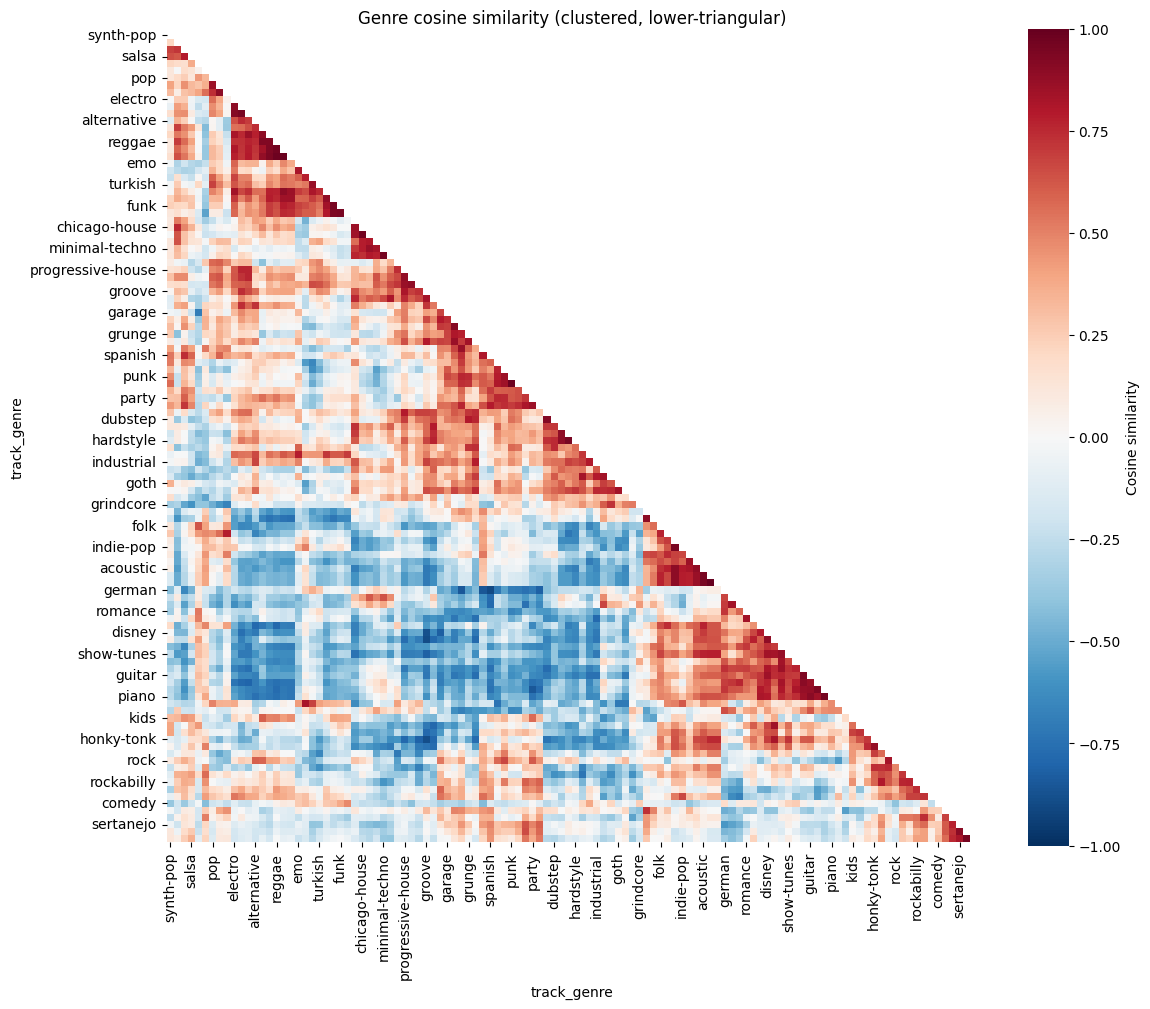

In [65]:
# 余弦相似度热图优化：聚类排序 + 上三角遮罩 + 发散色板
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

if 'sim_df' not in globals():
    raise NameError('Run the cosine similarity cell first to get sim_df')

# 距离矩阵（1 - 相似度），用层次聚类获取排序
condensed = pdist(scaled_agg.values, metric='cosine')
link = linkage(condensed, method='average')
order = leaves_list(link)
ordered_labels = agg.index[order]
ordered_sim = sim_df.loc[ordered_labels, ordered_labels]

# 只显示下三角，去掉对角线重复信息
mask = np.triu(np.ones_like(ordered_sim, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    ordered_sim,
    mask=mask,
    cmap='RdBu_r',
    vmin=-1, vmax=1, center=0,
    square=True,
    cbar_kws={'label': 'Cosine similarity'},
)
plt.title('Genre cosine similarity (clustered, lower-triangular)')
plt.tight_layout()
plt.show()
